# AHRS Filter/Fusion Viewer

## Load raw sensor data
To view different data, change the path in "data_source" to a folder containing your data. Refer to the CSV files within the "sample_data" folder for expected format.

In [1]:
%config IPCompleter.greedy=True
%matplotlib notebook
%reload_ext autoreload
%autoreload
import os
import numpy as np
import math
import quaternion_math
import fusion_6_axis
import matplotlib.pyplot as plt
import ipywidgets as widgets

data_source = "./sample_data"
NUM_HEADER_LINES = 4 # number of header lines in the file
TIME_INDEX = 0
ACCEL_INDEX = 1
GYRO_INDEX = 4
MAGN_INDEX = 7

TIME_SCALE = 0.000000001 # nanoseconds to seconds
ACCEL_SCALE = 1.0
GYRO_SCALE = 0.01745329251994329576923690768489 # degrees to radians
MAGN_SCALE = 1.0

CORRECTION_VEC = np.array([
    0,
    0.0, 0.0, 0.0, # accelerometer x,y,z corrections
    -0.035, -0.018, -0.015, # gyro x,y,z corrections
    0.0, 0.0, 0.0 # magnetometer x,y,z corrections
])

SCALE_VEC = np.array([
    TIME_SCALE,
    ACCEL_SCALE, ACCEL_SCALE, ACCEL_SCALE,
    GYRO_SCALE, GYRO_SCALE, GYRO_SCALE,
    MAGN_SCALE, MAGN_SCALE, MAGN_SCALE
])


raw_data_list = {} # dictionary to hold our data sets / file names


# Loop through our files to parse data
for root, dirs, files in os.walk(data_source, topdown=False):
    for name in files:
        # Fill in our array
        unscaled_data = np.genfromtxt(os.path.join(root, name), delimiter=',', dtype='f4', 
                                          skip_header=NUM_HEADER_LINES, encoding='ascii')
        scaled_data = np.multiply(unscaled_data, SCALE_VEC[None, :])
        raw_data_list[name] = np.add(scaled_data, CORRECTION_VEC[None, :])

## Filter & fuse the raw data

In [2]:
BETA = 0.6046
ZETA = 0.0076

NUM_FUSION_ITERATIONS = 3

fused_6_axis = {}
for key, value in raw_data_list.items():
    fused_6_axis[key] = []
   
    # Get initial orientation
    quat = quaternion_math.quat_from_accel(value[0][ACCEL_INDEX:(ACCEL_INDEX + 3)])
    time_prev = value[0][TIME_INDEX]
    
    # Fuse the rest of the data set
    for row in value[1:]:
        delta_t = row[TIME_INDEX] - time_prev
        time_prev = row[TIME_INDEX]
        
        # Iterate fusion n times for each data point
        for _ in range(NUM_FUSION_ITERATIONS):
            quat = fusion_6_axis.madgwick_update_6(
                quat, 
                row[ACCEL_INDEX:(ACCEL_INDEX + 3)], 
                row[GYRO_INDEX:(GYRO_INDEX + 3)], 
                delta_t, 
                BETA, 
                ZETA
            )
            
        tait_bryan = quaternion_math.quat_to_tait_bryan(quat)
        fused_6_axis[key].append(np.concatenate([quat, tait_bryan]))

## Plot the raw data

<IPython.core.display.Javascript object>


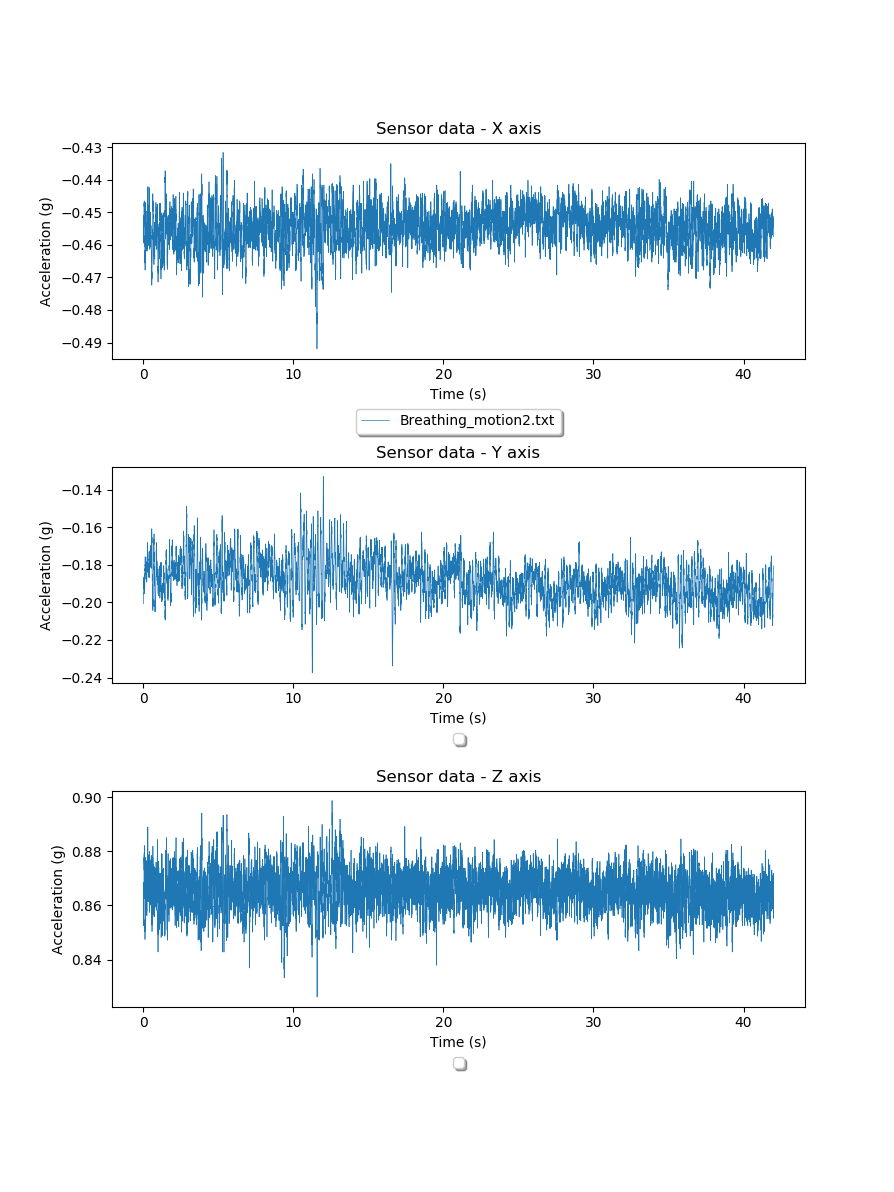

No handles with labels found to put in legend.
No handles with labels found to put in legend.


In [19]:
# Setup figure
plt.rcParams['figure.figsize'] = [9, 12]
plt.rcParams['lines.linewidth'] = 0.5
fig = plt.figure()

def update_plots(_):
    # Call the plot function associated with the data type
    data_types[data_type_select.value](file_name_select.value)
#     # For each data set selected
#     for item in unfiltered_data_select.value:
#         # Iterator to plot to the correct graph
#         i = 0
#         # For each column representing the data type
#         for column in data_type_columns[data_type_select.value]:
#             unfiltered_axes[i].plot(data_list[item][:,0], data_list[item][:,column])
#             i += 1
            
#     unfiltered_fig.show()
  
def format_plot(plot, title, x_label, y_label):
    # Add titles
    plot.set_title(title)
    plot.set_xlabel(x_label)
    plot.set_ylabel(y_label) 
    # Shrink current axis's height
    box = plot.get_position()
    plot.set_position([box.x0, box.y0 + box.height * 0.2,
                     box.width, box.height * 0.8])

    # Put a legend below current axis
    plot.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
              fancybox=True, shadow=True, ncol=4)
    
def plot_raw_data_type(file_names, data_type_index):
    fig.clf()
    
    x_plot = fig.add_subplot(3,1,1)
    y_plot = fig.add_subplot(3,1,2)
    z_plot = fig.add_subplot(3,1,3)
    
    for file_name in file_names:
        x_plot.plot(
            raw_data_list[file_name][:,TIME_INDEX], 
            raw_data_list[file_name][:,data_type_index], 
            label=file_name
        )
        y_plot.plot(raw_data_list[file_name][:,TIME_INDEX], raw_data_list[file_name][:,data_type_index + 1])
        z_plot.plot(raw_data_list[file_name][:,TIME_INDEX], raw_data_list[file_name][:,data_type_index + 2])
    
    format_plot(x_plot, "Sensor data - X axis", "Time (s)", "Acceleration (g)")
    format_plot(y_plot, "Sensor data - Y axis", "Time (s)", "Acceleration (g)")
    format_plot(z_plot, "Sensor data - Z axis", "Time (s)", "Acceleration (g)")
    fig.show()
    
# def plot_filtered_data(file_names):
#     fig.clf()
    
#     quat_plot = fig.add_subplot(2,1,1)
#     tait_bryan_plot = fig.add_subplot(2,1,2)
    
#     for file_name in file_names:
#         quat_plot.plot()
        
def plot_accel(file_names):
    plot_raw_data_type(file_names, ACCEL_INDEX)
    
def plot_gyro(file_names):
    plot_raw_data_type(file_names, GYRO_INDEX)
    
def plot_magn(file_names):
    plot_raw_data_type(file_names, MAGN_INDEX)

data_types = {
    'Accelerometer' : plot_accel,
    'Gyroscope' : plot_gyro,
    'Magnetometer' : plot_magn,
}

# Configure selection boxes
data_type_select = widgets.Select(
    options = data_types.keys(),
    description = 'Data type',
    disabled = False,
    layout = widgets.Layout(width = "300px")           
)
file_name_select = widgets.SelectMultiple(
    options= raw_data_list.keys(),
    description='Data sets',
    disabled = False,
    layout = widgets.Layout(width = "300px")
)

# Update plots button
update_plots_btn = widgets.Button(
    description="Update plots",
    disabled = False,
    layout = widgets.Layout(margin = "10px 0 20px 90px", border = "1px solid gray")
)  
update_plots_btn.on_click(update_plots)

# Display our widgets
widgets.VBox([update_plots_btn, widgets.HBox([data_type_select, file_name_select])])